# Präsenzversuch zum Laval-Rotor

Name:  Bianca Beer

Datum:  20.01.2024

Gruppe: 77

## Forschungsfrage

Wie unterscheiden sich die Campbell-Diagramme verschiedener Prüfstände? Welche Unterschiede kann man daran erkennen?

## Erster Versuch: Prüfstand #2
Hier werden Sie die Messergebnisse des ersten Prüfstands auswerten. Die Auswertung des zweiten Prüfstands kann analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.
Bitte ergänzen Sie im Titel der Markdown-Zellen die Nummer des Prüfstands

###  Versuchsaufbau
- Bild des Prüfstands:

<img src="figures/lavalrotor2.jpeg" width="500">

- Beschreibung des Aufbaus, gehen Sie auf die Anzahl der Scheiben und deren Gewicht ein:

Der Prüfstand besteht aus einer 75 cm langen Welle, die durch einen Motor kontrolliert (über einen Schaltkasten mit dem Raspberry Pi) angetrieben wird. Dort ist auch ein Drehzahlsensor angebracht. Die Welle wird an einem Ende (bei dem Motor) durch ein Festlager und am anderen durch ein Loslager gehalten. Dazwischen befinden sich zwei Scheiben mit einem Fanglager, jeweils nach 25 cm. Die Scheiben haben jeweils ein Gewicht von 500 g. 

### Versuchsauswertung

In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import importlib
import json

from functions import m_postprocessing

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1. Einlesen der Mess- und Metadaten

Beim Einlesen der Mess- und Metadaten geben wir Ihnen bereits eine Struktur vor. Es bietet sich an diese zu verwenden, ist aber nicht zwingend erforderlich.

##### 1.a) Angabe der Pfade und Dateinamen
Passen Sie die unten stehenden Pfade an, indem Sie `None` ersetzen.

In [2]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240119_104215_lavalrotor_77_02"
)  # path to the folder with H5-file and metadata
filename = "data_20240119_104215_lavalrotor_77_02.h5"  # name of the H5-file

##### 1.b) Preparieren der Metadaten
Wenn Sie die Pfade oben korrekt definiert haben, dann müssen Sie hier nichts anpassen. Schauen Sie sich die Struktur von `setup_dict` an und die zurückgegebenen IDs `uuid_acceleration` und `uuid_motor_rpm`.

In [3]:
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240119_104215_lavalrotor_77_02/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cc-06c7-631a-99e2-dc18593ae07a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240119_104215_lavalrotor_77_02/1ee823cc-06c7-631a-99e2-dc18593ae07a.json"
  },
  "1ee823b3-32d9-6d20-8261-106b0e021eed": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240119_104215_lavalrotor_77_02/1ee823b3-32d9-6d20-8261-106b0e021eed.json"
  },
  "1ee82398-0056-698f-8809-248cede81c54": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240119_104215_lavalrotor_77_02/1ee82398-0056-698f-8809-248cede81c54.json"
  },
  "1ee823d3-8511-6a0b-8cd5-972f083673c9": {
    "type": "sensor",
  

##### 1.c) Initialisieren der Datenstrukturen für die Messdaten
Hier wird der Vektor `interpolation_points` mit Stützstellen für die Interplation der Messdaten für alle Drehzahlen erzeugt. Dieses vereinfacht später die Darstellung des Campbell-Diagramms enorm.

Initialisieren Sie Datenstrukturen um alle nötigen Daten für das Campbell-Diragramm abspeichern zu können, verwenden Sie dazu ggf. `interpolation_points`.

Ich füge hier direkt einen weiteren Schritt hinzu, indem ich, statt die einzelnen Werte für x, y und z ins Dictionary einzutragen, direkt den absoluten Wert der gesamten Beschleunigung nehme.

In [4]:
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

In [5]:
# Dictionary zum Abspeichern der Datensätze
data = {}

# HDF5-Datei öffnen
path_h5_file = path_measurement_folder + "/" + filename
f = h5py.File(path_h5_file, "r")

for i in f.keys():
    
    # Eintrag in data für Messungsabschnitt (Drehzahl) erstellen
    data[i] = {}
    
    # Daten auslesen
    group_path = i+"/"+"RawData/"+uuid_acceleration   # Pfad zu den Mess-Datensätzen in HDF5-Datei
    group_data = f[group_path]

    # Einzeln Datensätze in numpy-arrays speichern
    acceleration_x = np.array(group_data["acceleration_x"])
    acceleration_y = np.array(group_data["acceleration_y"])
    acceleration_z = np.array(group_data["acceleration_z"])
    timestamp = np.array(group_data["timestamp"])
        
    # Betrag des Beschleunigungsvektors
    absolute_acc = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
    
    # Drehzahl auslesen
    drehzahl = int(np.array(f[i+"/"+"RawData/"+uuid_motor_rpm]["motor_rpm"]))
    
    # Daten zu data hinzufügen
    data[i]["absolute_acceleration"] = absolute_acc
    data[i]["timestamp"] = timestamp
    data[i]["drehzahl"] = drehzahl

#HDF5-Datei schließen
f.close()

#### 2. Verarbeitung der Messdaten

Verarbeiten Sie die Messdaten für alle untersuchten Drehzahlen mit `m_postprocessing.get_vec_accel()`, `m_postprocessing.interpolation()` und `m_postprocessing.my_fft_scaled()`.

In [6]:
importlib.reload(m_postprocessing)  # reload functions

# Dictionaries für Amplituden und Frequenzen nach FFT
scaled_amplitude_dict = {}
frequencies_dict = {}

# Liste für Drehzahlen
drehzahlen = []

for i in data.keys():
    
    # Interpolation der Messwerte
    int_data = m_postprocessing.interpolation(data[i]["timestamp"], data[i]["absolute_acceleration"], interpolation_points)
    
    # Interpolation zu data hinzufügen
    data[i]["interpolation"] = int_data
    
    # FFT durchführen
    scaled_amplitude, frequencies = m_postprocessing.my_fft_scaled(int_data, interpolation_points)
    
    # FFT-Daten zu Dictionaries hinzufügen
    scaled_amplitude_dict[str(i)] = scaled_amplitude
    frequencies_dict[str(i)] = frequencies
    
    # Drehzahl zur Drehzahlliste hinzufügen
    drehzahlen.append(data[i]["drehzahl"])
    
drehzahlen = np.array(drehzahlen)

[  55  133  822  898  968 1046 1120 1195 1271 1357 1422 1500  211 1587
 1648 1724 1807 1863 1948 2013 2098 2158 2240  286 2326 2381 2459 2543
 2609 2679 2778 2831 2887 2970  364 3030  441  516  594  667  741]
<class 'numpy.ndarray'>
2000
2000
999
1000
<class 'numpy.ndarray'>
[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3
  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4  2.5  2.6  2.7
  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8  3.9  4.   4.1
  4.2  4.3  4.4  4.5  4.6  4.7  4.8  4.9  5.   5.1  5.2  5.3  5.4  5.5
  5.6  5.7  5.8  5.9  6.   6.1  6.2  6.3  6.4  6.5  6.6  6.7  6.8  6.9
  7.   7.1  7.2  7.3  7.4  7.5  7.6  7.7  7.8  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.8 10.9 11.  11.1
 11.2 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5
 12.6 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9
 14.  14.1 14.

#### 3. Darstellung mittels Campbell-Diagramm

Erzeugen Sie hier ein Campbell-Diagramm aus den Messdaten.

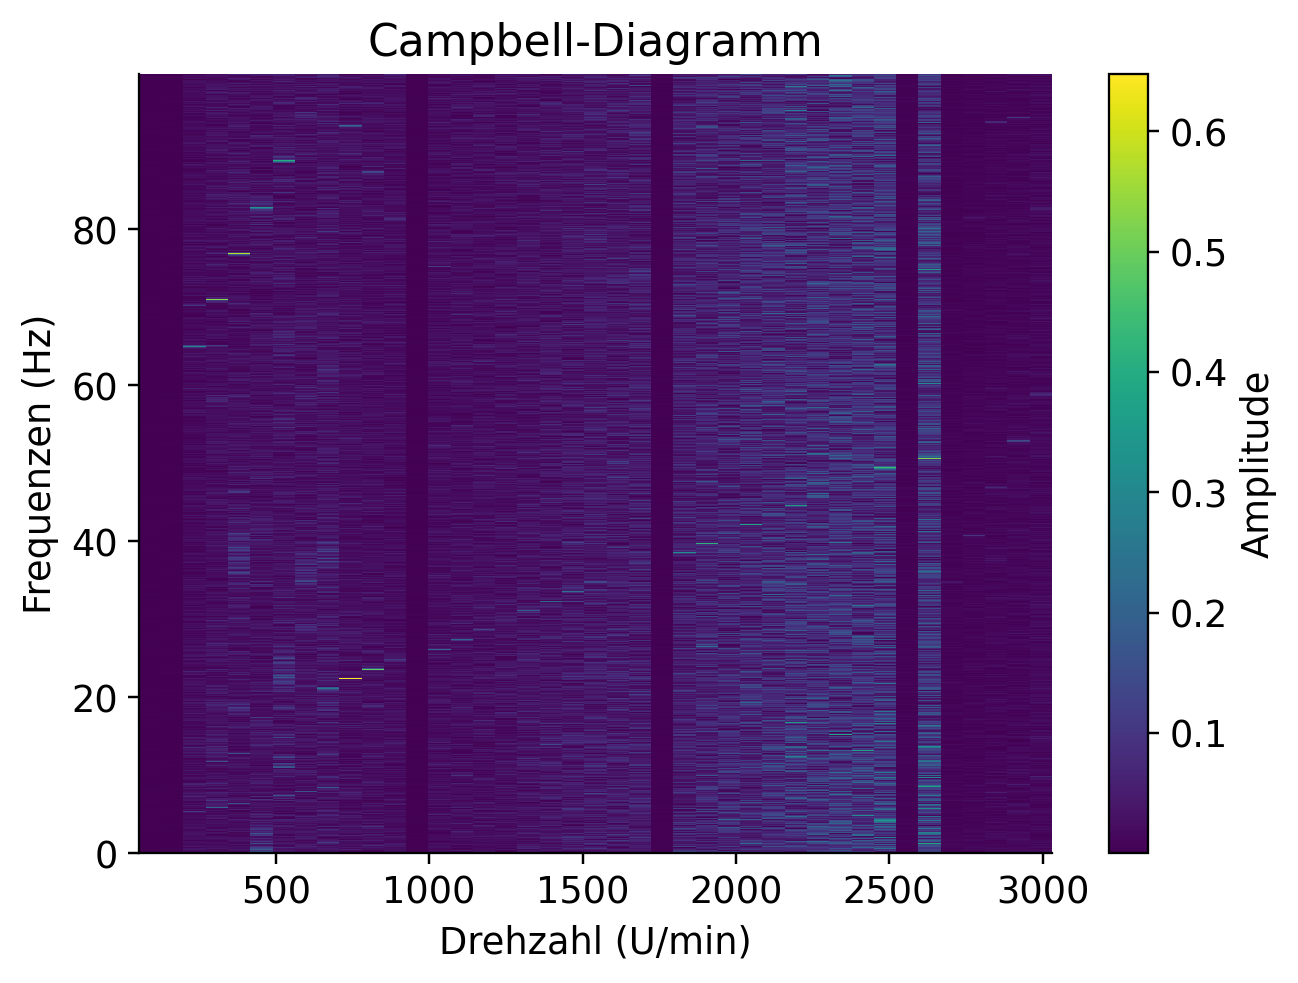

In [7]:
# Amplituden in Liste speichern
amp = [amp_list for amp_list in scaled_amplitude_dict.values()]

# listen von muximums und minimums der frequenzen
freq_min_list = [min_list[0] for min_list in frequencies_dict.values()]
freq_max_list = [max_list[-1] for max_list in frequencies_dict.values()]

# Campbell-Diagramm

plt.imshow(np.transpose(amp), extent=(min(drehzahlen), max(drehzahlen) , min(freq_min_list), max(freq_max_list)), 
           aspect='auto', cmap='viridis',interpolation="none", origin="lower")

plt.title('Campbell-Diagramm')
plt.xlabel('Drehzahl (U/min)')
plt.ylabel('Frequenzen (Hz)')
plt.colorbar(label='Amplitude')

plt.show()

## Zweiter Datensatz: Prüfstand #3

#### 1. Einlesen der Mess- und Metadaten

In [8]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

# Metadaten des setups auslesen
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

# UUIDs des Beschleunigungssensors und der Motorsteuerung auslesen
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

{
  "1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18": {
    "type": "group",
    "name": "group_info",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee4d7f7-565f-6f82-8db2-2cf8a3c4cb18.json"
  },
  "1ee823cd-7650-61c2-9b01-d4744d892e2a": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823cd-7650-61c2-9b01-d4744d892e2a.json"
  },
  "1ee823b5-5d9b-6f24-9817-906ef09da71d": {
    "type": "instrument",
    "name": "motor_controller",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee823b5-5d9b-6f24-9817-906ef09da71d.json"
  },
  "1ee8239a-489e-66bc-932e-2587341b8ad5": {
    "type": "actor",
    "name": "brushless_DC_motor",
    "comment": "",
    "path": "measurement_data/data_20240102_112539_lavalrotor_01_03/1ee8239a-489e-66bc-932e-2587341b8ad5.json"
  },
  "1ee823d5-1451-6df6-a364-c723014c91a1": {
    "type": "sensor",
  

#### 2. Verarbeitung der Messdaten

In [9]:
# --- Initialisieren der Datenstrukturen ---

# Liste für Zeitschritte für Interpolation erstellen
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# Dictionary zum Abspeichern der Datensätze
data = {}

# HDF5-Datei öffnen
path_h5_file = path_measurement_folder + "/" + filename
f = h5py.File(path_h5_file, "r")

for i in f.keys():
    
    # Eintrag in data für Messungsabschnitt (Drehzahl) erstellen
    data[i] = {}
    
    # Daten auslesen
    group_path = i+"/"+"RawData/"+uuid_acceleration   # Pfad zu den Mess-Datensätzen in HDF5-Datei
    group_data = f[group_path]

    # Einzeln Datensätze in numpy-arrays speichern
    acceleration_x = np.array(group_data["acceleration_x"])
    acceleration_y = np.array(group_data["acceleration_y"])
    acceleration_z = np.array(group_data["acceleration_z"])
    timestamp = np.array(group_data["timestamp"])
    
    # Betrag des Beschleunigungsvektors
    absolute_acc = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
    
    # Drehzahl auslesen
    drehzahl = int(np.array(f[i+"/"+"RawData/"+uuid_motor_rpm]["motor_rpm"]))
    
    # Daten zu data hinzufügen
    data[i]["absolute_acceleration"] = absolute_acc
    data[i]["timestamp"] = timestamp
    data[i]["drehzahl"] = drehzahl

#HDF5-Datei schließen
f.close()

# --- Messdaten verarbeiten ---
importlib.reload(m_postprocessing)  # reload functions

# Dictionaries für Amplituden und Frequenzen nach FFT
scaled_amplitude_dict = {}
frequencies_dict = {}

# Liste für Drehzahlen
drehzahlen = []

for i in data.keys():
    
    # Interpolation der Messwerte
    int_data = m_postprocessing.interpolation(data[i]["timestamp"], data[i]["absolute_acceleration"], interpolation_points)
    
    # Interpolation zu data hinzufügen
    data[i]["interpolation"] = int_data
    
    # FFT durchführen
    scaled_amplitude, frequencies = m_postprocessing.my_fft_scaled(int_data, interpolation_points)
    
    # FFT-Daten zu Dictionaries hinzufügen
    scaled_amplitude_dict[str(i)] = scaled_amplitude
    frequencies_dict[str(i)] = frequencies
    
    # Drehzahl zur Drehzahlliste hinzufügen
    drehzahlen.append(data[i]["drehzahl"])
    
drehzahlen = np.array(drehzahlen)

#### 3. Darstellung mittels Campbell-Diagramm

In [10]:
campbell_diagram = np.zeros((len(eigenfrequencies), len(rotor_speeds)))
for i, freq in enumerate(eigenfrequencies):
    for j, speed in enumerate(rotor_speeds):
        # Simulation des Messsignals für die aktuelle Rotordrehzahl und Eigenfrequenz
        # Hier sollte die tatsächliche Berechnung des Signals durchgeführt werden
        time = np.linspace(0, 1, 1000)  # Beispiel-Zeitvektor
        signal = np.sin(2 * np.pi * speed * freq * time)
        # Berechne die FFT des Signals mit der skalierten Amplitude
        scaled_amplitude, frequencies = my_fft_scaled(signal, time)
        # Extrahiere die Amplitude der Eigenfrequenz
        eigenfreq_index = np.abs(frequencies - freq).argmin()
        campbell_diagram[i, j] = scaled_amplitude[eigenfreq_index]
#return campbell_diagram

# Definiere die Rotordrehzahl-Bereiche und die Eigenfrequenzen des Systems
rotor_speeds = np.linspace(1, 100, 100)  # Rotordrehzahlen von 1 bis 100 U/min
eigenfrequencies = np.array([10, 20, 30])  # Beispiel-Eigenfrequenzen in Hz

# Berechne das Campbell-Diagramm
campbell_diagram = calculate_campbell_diagram(rotor_speeds, eigenfrequencies)

# Plotte das Campbell-Diagramm
plt.imshow(campbell_diagram, aspect='auto', origin='lower',
           extent=[eigenfrequencies[0], eigenfrequencies[-1], rotor_speeds[0], rotor_speeds[-1]])
plt.xlabel('Eigenfrequenz (Hz)')
plt.ylabel('Rotordrehzahl (U/min)')
plt.title('Campbell-Diagramm')

NameError: name 'eigenfrequencies' is not defined

## Dritter Datensatz: Prüfstand #X

#### 1. Einlesen der Mess- und Metadaten

In [ ]:
path_measurement_folder = os.path.join(
    "measurement_data", "data_20240102_112539_lavalrotor_01_03"
)  # path to the folder with H5-file and metadata
filename = "data_20240102_112539_lavalrotor_01_03.h5"  # name of the H5-file

# Metadaten des setups auslesen
setup_dict = m_postprocessing.evaluate_measurement_metadata(path_measurement_folder)
print(json.dumps(setup_dict, indent=2, default=str))

# UUIDs des Beschleunigungssensors und der Motorsteuerung auslesen
uuid_acceleration, uuid_motor_rpm = m_postprocessing.extract_uuid(setup_dict)

#### 2. Verarbeitung der Messdaten

In [ ]:
# --- Initialisieren der Datenstrukturen ---

# Liste für Zeitschritte für Interpolation erstellen
measurement_time_in_s = 10
number_interpolation_points = 2000

interpolation_points = np.linspace(measurement_time_in_s/number_interpolation_points, measurement_time_in_s, number_interpolation_points, endpoint=True)

# Dictionary zum Abspeichern der Datensätze
data = {}

# HDF5-Datei öffnen
path_h5_file = path_measurement_folder + "/" + filename
f = h5py.File(path_h5_file, "r")

for i in f.keys():
    
    # Eintrag in data für Messungsabschnitt (Drehzahl) erstellen
    data[i] = {}
    
    # Daten auslesen
    group_path = i+"/"+"RawData/"+uuid_acceleration   # Pfad zu den Mess-Datensätzen in HDF5-Datei
    group_data = f[group_path]

    # Einzeln Datensätze in numpy-arrays speichern
    acceleration_x = np.array(group_data["acceleration_x"])
    acceleration_y = np.array(group_data["acceleration_y"])
    acceleration_z = np.array(group_data["acceleration_z"])
    timestamp = np.array(group_data["timestamp"])
    
    # Betrag des Beschleunigungsvektors
    absolute_acc = m_postprocessing.get_vec_accel(acceleration_x, acceleration_y, acceleration_z)
    
    # Drehzahl auslesen
    drehzahl = int(np.array(f[i+"/"+"RawData/"+uuid_motor_rpm]["motor_rpm"]))
    
    # Daten zu data hinzufügen
    data[i]["absolute_acceleration"] = absolute_acc
    data[i]["timestamp"] = timestamp
    data[i]["drehzahl"] = drehzahl

#HDF5-Datei schließen
f.close()

# --- Messdaten verarbeiten ---
importlib.reload(m_postprocessing)  # reload functions

# Dictionaries für Amplituden und Frequenzen nach FFT
scaled_amplitude_dict = {}
frequencies_dict = {}

# Liste für Drehzahlen
drehzahlen = []

for i in data.keys():
    
    # Interpolation der Messwerte
    int_data = m_postprocessing.interpolation(data[i]["timestamp"], data[i]["absolute_acceleration"], interpolation_points)
    
    # Interpolation zu data hinzufügen
    data[i]["interpolation"] = int_data
    
    # FFT durchführen
    scaled_amplitude, frequencies = m_postprocessing.my_fft_scaled(int_data, interpolation_points)
    
    # FFT-Daten zu Dictionaries hinzufügen
    scaled_amplitude_dict[str(i)] = scaled_amplitude
    frequencies_dict[str(i)] = frequencies
    
    # Drehzahl zur Drehzahlliste hinzufügen
    drehzahlen.append(data[i]["drehzahl"])
    
drehzahlen = np.array(drehzahlen)

#### 3. Darstellung mittels Campbell-Diagramm

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

##### Vergleich der gemessenen mit der analytisch berechneten kritischen Drehzahl
Sie können für den Vergleich, falls benötigt auch Code Cells einfügen.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.